# BioSound Tutorial 5.  Using the MPS as features for classifiers.
### In tutorial 4, you learned how to use predefined acoustical features such as pitch saliency to classify sounds.  Here you will use a spectrogram or modulation power spectrum.  The plotDiscriminate routine performs a PCA on these large feature spaces to prevent over-fitting 

Some things to note:  The spectrogram approach will only work if all BioSound files have the same size spectrogam.  This usually means the same sound length and the same time-frequency scale. Here spectrograms are cut to the smallest soud. It also makes sense to have a logical alignment since the approach will be sensitive to shifts. This code can easily be modified to also use the modulation power spectrum. 
The modulation spectrum allows for variable size sounds and is insensitive to shifts but the analysis window for the MPS must be identical and it must be based on spectrograms that were obtained with the same time-frequency scale.

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas, pickle and sklearn.

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 
from soundsig.discriminate import discriminatePlot
import pickle
from sklearn.decomposition import PCA
from scipy.stats import f, fisher_exact
from statsmodels.stats.proportion import binom_test


import matplotlib.pyplot as plt

import os


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE  
You will also want to change the location for storing the pandas table.  
Note that you might want to also change the name of the h5 file that stores all of the spectrograms.

In [2]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/cry_sequences_22babies/h5files')

# Some output files
tableStore = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocSelTableMPS.h5'
pcInfo = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocMPSPC.pkl'


# This is where you want to store eps of figures that will be generated.
figdir = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/'

# Read csv file with baby gender.
babyInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/Banque_data_tous.csv', delimiter= ';', index_col = 0)

# Subject performance to compare with classifier
subjectInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/success_2tests.csv', 
                       delimiter= ';', index_col = False, decimal = ',')
# Color map
cmap = plt.get_cmap('jet')

## Step 3. Looping through a set of bioSoundObjects to extract the modulation power spectrum and storing them into a Pandas Data Frame.

#### Part 1. Extract MPS (or Spectrograms); normalize if desired; and compress by PCA

Here we are doing the PC to store the data efficiently.  Unless you have a ton of data the classifier will only use a small number of these anyway.  The first PCA is to reduce from the ~25000 (for these data) space of spectrogram to a space of 50.  As you will see this is able to capture almost 90% of the variance.

In [3]:
# Read first one to set up plotting parameters and store the size of the MPS and count the other ones (lazy code...)

count = 0
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        if (count == 0):
            myBioSound = BioSound()
            myBioSound.readh5(fname)        
        count += 1

# Cut the mps to central region 
wfInd = np.argwhere(myBioSound.wf >= 0).flatten()
wtInd = np.argwhere((myBioSound.wt >= -50) & (myBioSound.wt <=50) ).flatten()

shapeDesired = (len(wfInd), len(wtInd))

ex = (myBioSound.wt[wtInd[0]], myBioSound.wt[wtInd[-1]], myBioSound.wf[wfInd[0]]*1e3, myBioSound.wf[wfInd[-1]]*1e3)





You can skip to the classification section if you already have the PCAs of the MPS

In [4]:
# Allocate space for MPS - you can skip the next set of cells if you already have the PCA

X = np.zeros((count, shapeDesired[0]*shapeDesired[1]))
print('Allocated space for all MPS') 

wfi, wtj = np.meshgrid(wfInd, wtInd, indexing = 'ij')

Allocated space for all MPS


In [5]:
wf0 = np.argwhere(myBioSound.wf == 0).flatten()[0]
wt0 = np.argwhere(myBioSound.wt == 0).flatten()[0]

In [6]:
# Loop again to extract the central section of the MPS and store the in X 

# Looping again through all the files
count = 0
dcVals = []
sumVals = []
babyIDs = []
sexIDs = []
condIDs = []
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        X[count,:] = np.log(np.ravel(myBioSound.mps[wfi, wtj]))
        
        # These are our three identifiers - the emitter (baby), the sex and the type of cry
        baby = myBioSound.emitter.tobytes().decode('UTF-8')
        sex = babyInfo.loc[baby]['sex']
        condition = myBioSound.type.tobytes().decode('UTF-8')
        babyIDs.append(baby)
        sexIDs.append(sex)
        condIDs.append(condition)
        
        dcval = np.log(myBioSound.mps[wf0, wt0])
        sumval = np.sum(X[count,:])
        dcVals.append(dcval)
        sumVals.append(sumval)
        
        count +=1
            
print('Read %d files and mps' % count)
print('DC: Mean = ', np.mean(dcVals), 'SD = ', np.std(dcVals), 'CV = ', np.std(dcVals)/np.mean(dcVals))
print('Sum: Mean = ', np.mean(sumVals), 'SD = ', np.std(sumVals), 'CV = ', np.std(sumVals)/np.mean(sumVals))




Read 286 files and mps
DC: Mean =  8.819961876900114 SD =  0.4842324367647433 CV =  0.05490187412634632
Sum: Mean =  -17230.966132596037 SD =  1954.8352478199909 CV =  -0.11344896349845435


In [7]:
# Perform an initial dimensionality reduction.
#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 20

print('Performing PCA')

pca = PCA(n_components=nPCs)
Xr = pca.fit_transform(X)  
 
# Write PCA information in pkl                         
pcInfoFile = open(pcInfo, 'wb')
pcaComps = pca.components_
pickle.dump(pcaComps, pcInfoFile)
pcInfoFile.close()

print('PCA Done: Wrote PC\'s to pickle file %s' % pcInfo)
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

Performing PCA
PCA Done: Wrote PC's to pickle file /Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocMPSPC.pkl
Variance explained is 62.62%


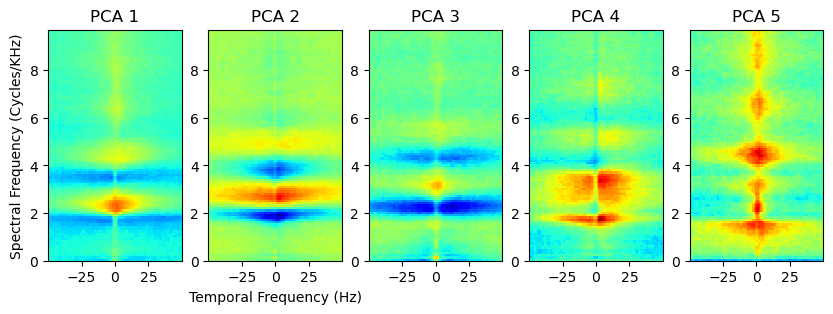

In [8]:
# Display the first 5 PCs


NPLOTS = 5

plt.figure(figsize=(10,3))
plt.clf()


ex = (myBioSound.wt[wtInd[0]], myBioSound.wt[wtInd[-1]], myBioSound.wf[wfInd[0]]*1e3, myBioSound.wf[wfInd[-1]]*1e3)

for iplot in range(NPLOTS):
    plt.subplot(100+NPLOTS*10+1+iplot)
    MPS = np.reshape(pca.components_[iplot], (shapeDesired[0],shapeDesired[1]))
    maxMPS = MPS.max()
    
    #minMPS = maxMPS-DBNOISE
    # logMPS[logMPS < minMPS] = minMPS
    plt.imshow(MPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    if (iplot == 0) :
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
    if (iplot == 1) :
        plt.xlabel('Temporal Frequency (Hz)')

    plt.clim(-0.05, 0.05)
    plt.title('PCA %d' % (iplot+1))
 
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/MPS_PCA.eps')
plt.show()


In [9]:
# Make the pandas data frame with all the MPS
vocSelData = []
for ic in range(count):         
    vocSelData.append({"Baby": babyIDs[ic], 
                       "Sex": sexIDs[ic], "Condition": condIDs[ic],
                       "MPS": Xr[ic]}) 
     

# Make a panda data frame with all the data  
print('Reprocessed %d files to make Panda Data Frame'%count)                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')
print('Done: Wrote pandas data frame to h5 file %s' % tableStore)

Reprocessed 286 files to make Panda Data Frame
Done: Wrote pandas data frame to h5 file /Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocSelTableMPS.h5


/var/folders/qr/wbdjwgd52jd_37tystfbwt040000gn/T/ipykernel_37746/3112086899.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Baby', 'Sex', 'Condition', 'MPS'], dtype='object')]

  vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')


## Step 5.  Run the Classifiers.  
### You can also run only this code after reading vocSelTable

In [4]:
# You can start here (after loading dependencies) or skip if you already have vocSelTable

#Read the pandas table
vocSelTable = pd.read_hdf(tableStore)

# Read the pc files
pcInfoFile = open(pcInfo, 'rb')
pcaComps = pickle.load(pcInfoFile)
pcInfoFile.close()


In [5]:
# This code is very similar to tutorial 4.
#  Here we generate colors for each baby for plotting purposes:

# Color code for bird ID
babyColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]


responseVar = 'Baby'

birdNames = np.unique(vocSelTable[responseVar])

# If you have a small number of birds you might want to choose specific colors
babyColor = {}
ib = 0
for birdId in birdNames:
    if ib < 4:
       babyColor[birdId] = babyColorStart[ib] 
    else:
       babyColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBabyAll = []
for babyId in vocSelTable[responseVar]:
    cValBabyAll.append(babyColor[babyId])
    
cValBabyAll = np.asarray(cValBabyAll)

In [6]:
# Regenerating Xr and Y since we might be reating from vocSelTable (disk)
y = np.array(vocSelTable[responseVar])

# Recover Xr from vocSelTable
nrow = len(vocSelTable)
nfeat = len(vocSelTable['MPS'][0])
Xr = np.zeros((nrow, nfeat))
for irow in range(nrow):
    Xr[irow,:] = vocSelTable['MPS'].array[irow]

# As always it is wise to exclude entries with missing data (should not happen here)
nonanInd = (np.sum(np.isnan(Xr), axis = 1) == 0)


Variance explained is 80.64%


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/fre

DFA calculated with 286 points
LDA Weights:
DFA 0: C1 0.047; C0 0.036; C3 -0.028; C5 0.021; C2 0.017; 
DFA 1: C3 -0.071; C4 0.063; C6 0.043; C0 -0.016; C2 0.016; 
DFA 2: C0 0.032; C1 -0.030; C2 -0.029; C6 -0.028; C3 -0.022; 


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 22. Chance level 4.55 %
MPS LDA: 34.97 % (100/286 p=0.0000)
MPS QDA: 25.52 % (73/286 p=0.0000)
MPS RF: 31.12 % (89/286 p=0.0000)


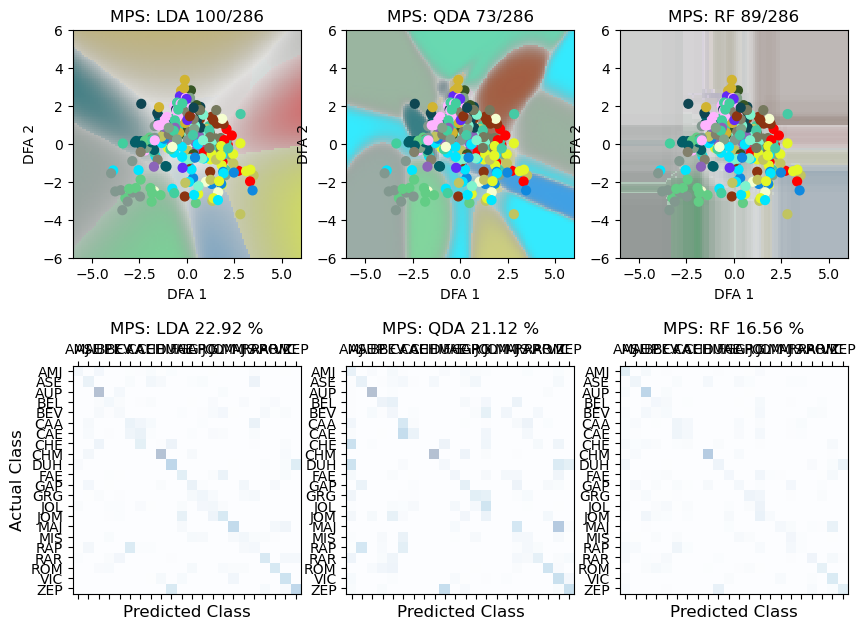

In [7]:
# This code is very similar to tutorial 4.
#  Now we perform the supervised cross-validated and regularized classification:

# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(Xr[nonanInd], y[nonanInd], 
                                                                                      cValBabyAll[nonanInd], 
                                                                                      titleStr='MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True)


#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['Mixed']),
     'Features': np.array(['MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
    }
     
resultsDataFrame = pd.DataFrame(data = d)



If you compare the results here to those obtained with predefined acoustical features, you see that we do slightly better with the mps

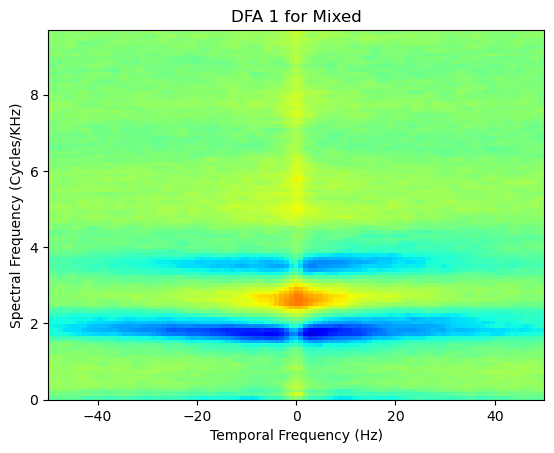

In [9]:
# Calculate the DFA in MPS domain and display.

dfaMPS = np.dot(weights,pcaComps)

plt.figure()
logMPS = np.reshape(dfaMPS[0,:], (shapeDesired[0], shapeDesired[1]))

plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.clim(-0.005, 0.005)
plt.title('DFA 1 for Mixed')
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/MPS_DFA1_Mixed.eps')

### Repeat the analysis with cross-validation

Variance explained is 79.15%


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 189 points
LDA Weights:
DFA 0: C3 0.110; C4 -0.068; C2 -0.066; C1 -0.021; C6 -0.014; 
DFA 1: C0 0.047; C1 0.044; C4 -0.018; C3 0.014; C5 -0.009; 
DFA 2: C4 0.043; C0 0.034; C2 -0.033; C3 -0.029; C1 -0.028; 


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 19. Chance level 5.26 %
Cross MPS LDA: 14.47 % (11/76 p=0.0021)
Cross MPS QDA: 6.58 % (5/76 p=0.3711)
Cross MPS RF: 19.74 % (15/76 p=0.0000)


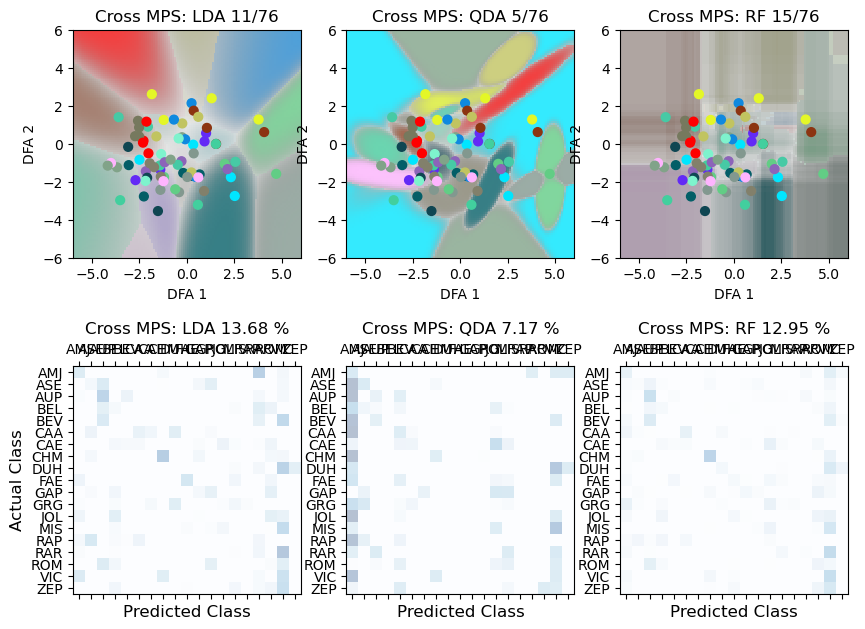

In [10]:
# The classifier

cond = np.array(vocSelTable['Condition'])
# Test on vaccination
testInd = (cond[nonanInd] == 'D')
#testInd = np.argwhere(cond[nonanInd] == 'D').flatten()

ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(Xr[nonanInd], y[nonanInd], 
                                                                                      cValBabyAll[nonanInd], 
                                                                                      titleStr='Cross MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True,
                                                                                      testInd = testInd)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['B for D']),
     'Features': np.array(['Cross MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
    }
     

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

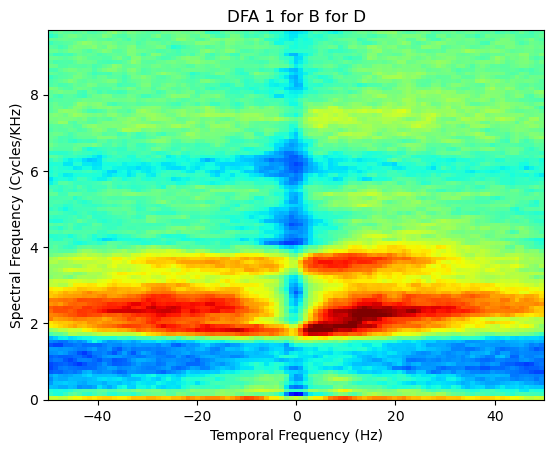

In [11]:
# Calculate the DFA in MPS domain and display.

dfaMPS = np.dot(weights,pcaComps)

plt.figure()
logMPS = np.reshape(dfaMPS[0,:], (shapeDesired[0], shapeDesired[1]))

plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.clim(-0.005, 0.005)
plt.title('DFA 1 for B for D')
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/MPS_DFA1_Bath.eps')

Variance explained is 79.65%


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/fre

DFA calculated with 184 points
LDA Weights:
DFA 0: C3 0.107; C2 -0.068; C4 -0.063; C1 -0.025; C15 0.014; 
DFA 1: C0 0.047; C1 0.044; C4 -0.027; C3 0.023; C7 -0.010; 
DFA 2: C4 0.046; C0 0.037; C2 -0.033; C3 -0.027; C1 -0.026; 


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 18. Chance level 5.56 %
Bath MPS LDA: 55.98 % (103/184 p=0.0000)
Bath MPS QDA: 33.15 % (61/184 p=0.0000)
Bath MPS RF: 39.67 % (73/184 p=0.0000)


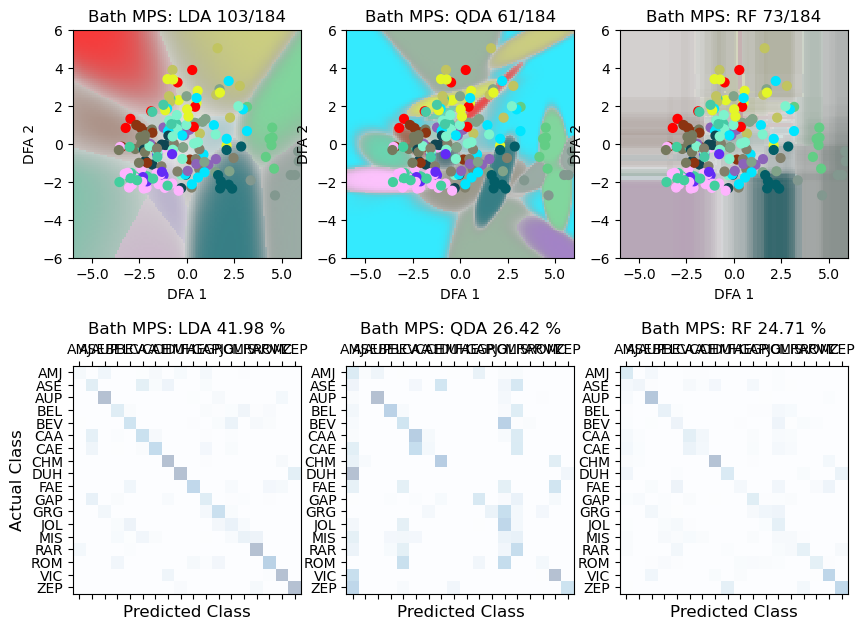

In [12]:
# Repeat for within Bath.
bathInd = np.argwhere(np.array(vocSelTable['Condition']) == 'B').flatten()

# Select a subset of rows.
XrBath = Xr[bathInd]
yBath = y[bathInd]
cValBath = cValBabyAll[bathInd]

# As always it is wise to exclude entries with missing data (should not happen here)
nonanInd = (np.sum(np.isnan(XrBath), axis = 1) == 0)


# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, bathClasses, nClasses, weights = discriminatePlot(XrBath[nonanInd], yBath[nonanInd], 
                                                                                      cValBath[nonanInd], 
                                                                                      titleStr='Bath MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['Bath']),
     'Features': np.array(['MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])      
    }
     
dBaby = {'Type': np.array(['Bath']*nClasses),
         'Features': np.array(['MPS']*nClasses),
         'Baby': bathClasses,
         'LDA': np.diag(lda_conf),
         'QDA': np.diag(qda_conf),
         'RF': np.diag(rf_conf)   }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

babyDataFrame = pd.DataFrame(data=dBaby)

Variance explained is 61.74%


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/fre

DFA calculated with 72 points
LDA Weights:
DFA 0: C0 -0.051; C1 -0.030; C2 0.030; C3 0.019; C5 -0.012; 
DFA 1: C1 0.042; C2 0.030; C3 -0.023; C4 -0.015; C0 -0.015; 
DFA 2: C2 0.043; C0 0.015; C5 -0.005; C3 -0.004; C4 -0.004; 
Number of classes 18. Chance level 5.56 %
Pain MPS LDA: 23.61 % (17/72 p=0.0000)
Pain MPS QDA: 0.00 % (0/72 p=1.0000)
Pain MPS RF: 20.83 % (15/72 p=0.0000)


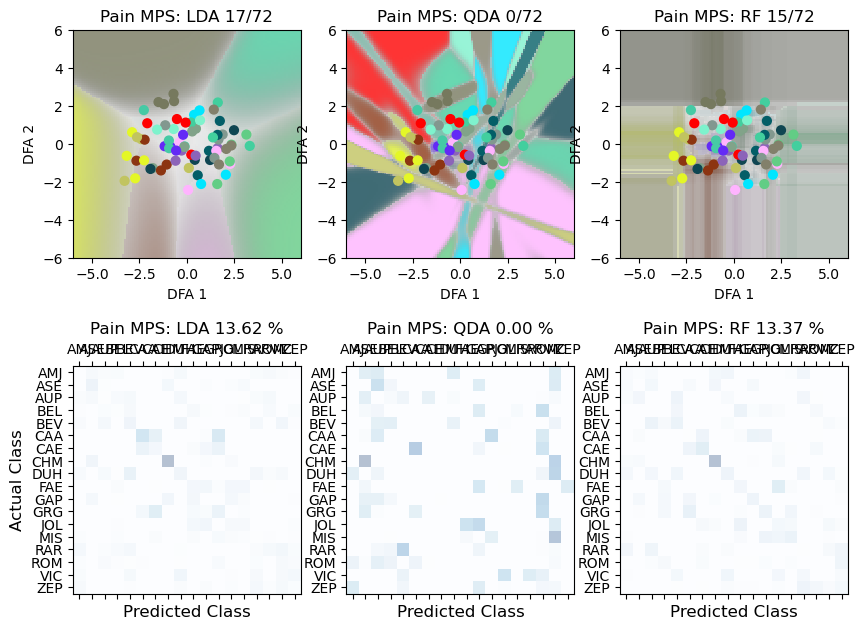

In [13]:
# Repeat for within Pain for the same babies as bath
# Repeat mix but with the same babies
babyInd = np.array([i for i, baby in enumerate(y) if baby in bathClasses])

XrBaby = Xr[babyInd]
yBaby = y[babyInd]
cValBaby = cValBabyAll[babyInd]

painInd = np.argwhere(np.array(vocSelTable['Condition'][babyInd]) == 'D').flatten()

# Select a subset of rows.
XrPain = XrBaby[painInd]
yPain = yBaby[painInd]
cValPain = cValBaby[painInd]

# As always it is wise to exclude entries with missing data (should not happen here)
nonanInd = (np.sum(np.isnan(XrPain), axis = 1) == 0)


# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XrPain[nonanInd], yPain[nonanInd], 
                                                                                      cValPain[nonanInd], 
                                                                                      titleStr='Pain MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True, 
                                                                                      MINCOUNTTRAINING=3)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['Pain']),
     'Features': np.array(['MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])      
    }
     
dBaby = {'Type': np.array(['Pain']*nClasses),
         'Features': np.array(['MPS']*nClasses),
         'Baby': classes,
         'LDA': np.diag(lda_conf),
         'QDA': np.diag(qda_conf),
         'RF': np.diag(rf_conf)   }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

babyDataFrame = pd.DataFrame(data=dBaby)

Variance explained is 81.93%
DFA calculated with 256 points
LDA Weights:
DFA 0: C3 0.048; C1 -0.044; C0 -0.031; C5 -0.022; C2 -0.020; 
DFA 1: C3 -0.070; C4 0.033; C6 0.031; C0 -0.027; C2 0.025; 
DFA 2: C6 -0.054; C2 0.046; C4 -0.041; C7 -0.027; C0 -0.022; 
Number of classes 18. Chance level 5.56 %
Bath-Mixed MPS LDA: 39.45 % (101/256 p=0.0000)
Bath-Mixed MPS QDA: 31.64 % (81/256 p=0.0000)
Bath-Mixed MPS RF: 39.45 % (101/256 p=0.0000)


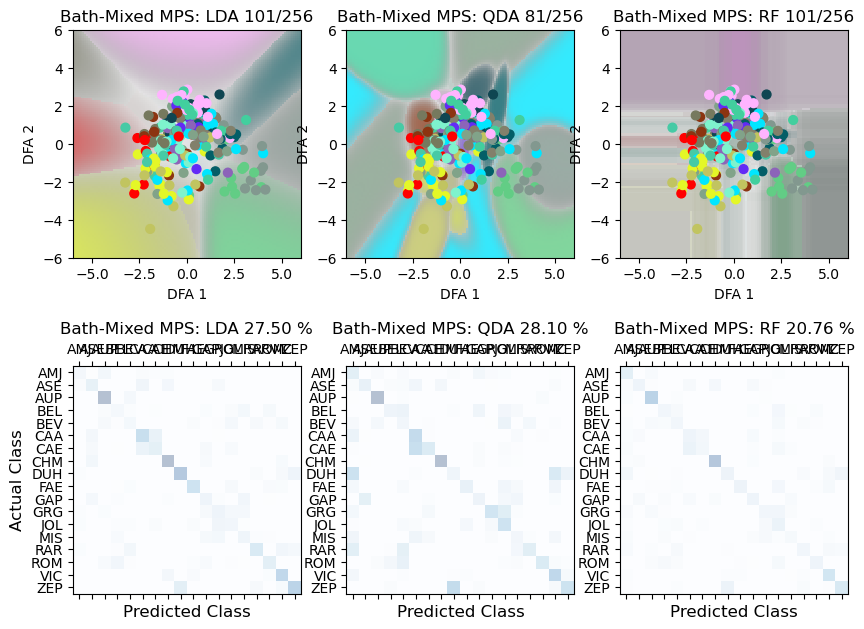

In [14]:
# Repeat mix but with the same babies (same code as in cell above but here for redundancy in case they are not run in the same order)
babyInd = np.array([i for i, baby in enumerate(y) if baby in bathClasses])

XrBaby = Xr[babyInd]
yBaby = y[babyInd]
cValBaby = cValBabyAll[babyInd]

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XrBaby), axis = 1) == 0)

# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XrBaby[nonanInd], yBaby[nonanInd], 
                                                                                      cValBaby[nonanInd], 
                                                                                      titleStr='Bath-Mixed MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['Bath-Mixed']),
     'Features': np.array(['MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])    
    }
     

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

dBaby = {'Type': np.array(['Bath-Mixed']*nClasses),
         'Features': np.array(['MPS']*nClasses),
         'Baby': classes,
         'LDA': np.diag(lda_conf),
         'QDA': np.diag(qda_conf),
         'RF': np.diag(rf_conf)   }

tempdfBaby = pd.DataFrame(data=dBaby)
babyDataFrame = pd.concat([babyDataFrame, tempdfBaby], ignore_index = True)



Variance explained is 79.65%


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 184 points
LDA Weights:
DFA 0: C3 0.107; C2 -0.068; C4 -0.063; C1 -0.025; C15 0.014; 
DFA 1: C0 0.047; C1 0.044; C4 -0.027; C3 0.023; C7 -0.010; 
DFA 2: C4 0.046; C0 0.037; C2 -0.033; C3 -0.027; C1 -0.026; 


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 18. Chance level 5.56 %
Bath-Crossed MPS LDA: 18.06 % (13/72 p=0.0002)
Bath-Crossed MPS QDA: 9.72 % (7/72 p=0.1047)
Bath-Crossed MPS RF: 19.44 % (14/72 p=0.0000)


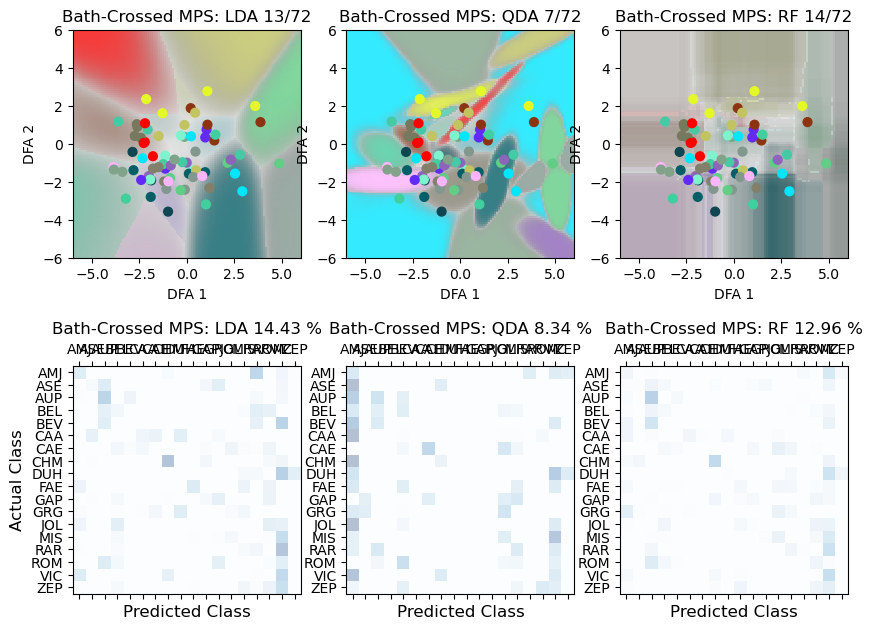

In [15]:
# Repeat cross but with the same babies
cond = np.array(vocSelTable['Condition'])

XrBaby = Xr[babyInd]
yBaby = y[babyInd]
cValBaby = cValBabyAll[babyInd]
condBaby = cond[babyInd]


# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XrBaby), axis = 1) == 0)

# Test on vaccination
testInd = (condBaby[nonanInd] == 'D')
# np.argwhere(condBaby[nonanInd] == 'D').flatten()   # this line is wrong. testInd should be a boolean array of true false

# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XrBaby[nonanInd], yBaby[nonanInd], 
                                                                                      cValBaby[nonanInd], 
                                                                                      titleStr='Bath-Crossed MPS', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True,
                                                                                      testInd = testInd)


#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['Bath-Crossed']),
     'Features': np.array(['MPS']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])    
    }
     

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

dBaby = {'Type': np.array(['Bath-Crossed']*nClasses),
         'Features': np.array(['MPS']*nClasses),
         'Baby': classes,
         'LDA': np.diag(lda_conf),
         'QDA': np.diag(qda_conf),
         'RF': np.diag(rf_conf)   }

tempdfBaby = pd.DataFrame(data=dBaby)
babyDataFrame = pd.concat([babyDataFrame, tempdfBaby], ignore_index = True)

In [16]:
resultsDataFrame['Avg Post']=(resultsDataFrame['LDA Post']+resultsDataFrame['QDA Post']+resultsDataFrame['RF Post'])/3.0
resultsDataFrame['Avg 2SE']= 2.0* np.sqrt(((resultsDataFrame['LDA Post 2SE']/2)**2+(resultsDataFrame['QDA Post 2SE']/2)**2+(resultsDataFrame['RF Post 2SE']/2)**2)/9.0)

babyDataFrame['Avg']=(babyDataFrame['LDA']+babyDataFrame['QDA']+babyDataFrame['RF'])/3.0

In [17]:
resultsDataFrame.style.format(precision = 1)
babyDataFrame.style.format(precision = 3)

,Type,Features,Baby,LDA,QDA,RF,Avg
0,Pain,MPS,AMJ,0.014,0.000,0.090,0.035
1,Pain,MPS,ASE,0.174,0.000,0.050,0.075
2,Pain,MPS,AUP,0.058,0.000,0.045,0.034
3,Pain,MPS,BEL,0.061,0.000,0.040,0.034
4,Pain,MPS,BEV,0.163,0.000,0.185,0.116
5,Pain,MPS,CAA,0.293,0.000,0.058,0.117
6,Pain,MPS,CAE,0.126,0.000,0.235,0.120
7,Pain,MPS,CHM,0.569,0.000,0.520,0.363
8,Pain,MPS,DUH,0.157,0.000,0.170,0.109
9,Pain,MPS,FAE,0.128,0.000,0.140,0.089


In [18]:
resultsDataFrame

,Type,Features,LDA Correct,QDA Correct,RF Correct,Tested,nClasses,LDA %,QDA %,RF %,...,QDA Pval,RF Pval,LDA Post,QDA Post,RF Post,LDA Post 2SE,QDA Post 2SE,RF Post 2SE,Avg Post,Avg 2SE
0,Mixed,MPS,100,73,89,286,22,34.965035,25.524476,31.118881,...,1.121023e-33,2.059943e-48,22.924747,21.122914,16.558636,4.971148,4.827245,4.395922,20.202099,2.735339
1,B for D,Cross MPS,11,5,15,76,19,14.473684,6.578947,19.736842,...,3.711155e-01,8.729186e-06,13.679093,7.165525,12.947368,7.883333,5.917004,7.702025,11.263995,4.169720
2,Bath,MPS,103,61,73,184,18,55.978261,33.152174,39.673913,...,9.701297e-31,1.262257e-42,41.983033,26.422510,24.714315,7.276717,6.501007,6.359919,31.039953,3.882472
3,Pain,MPS,17,0,15,72,18,23.611111,0.000000,20.833333,...,1.000000e+00,8.293050e-06,13.616607,0.000000,13.375000,8.083758,0.000000,8.022916,8.997202,3.796407
4,Bath-Mixed,MPS,101,81,101,256,18,39.453125,31.640625,39.453125,...,1.432664e-38,4.889154e-58,27.500010,28.103059,20.764801,5.581429,5.618780,5.070292,25.455957,3.134590
5,Bath-Crossed,MPS,13,7,14,72,18,18.055556,9.722222,19.444444,...,1.046637e-01,3.725535e-05,14.427656,8.343725,12.958333,8.281869,6.518157,7.915930,11.909905,4.393653


In [19]:
# Perform the binomial and the Fisher Exact Tests

# Bath vs Mixed.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['Tested'].iloc[0] - c
print('Comparing Bath to Mixed:', fisher_exact(np.array([[a, b], [c, d]])))

chanceP = 1.0/resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['nClasses'].iloc[0]
print('Comparing Bath to chance:', binom_test(a, a+b, prop=chanceP, alternative='larger'))
chanceP = 1.0/resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['nClasses'].iloc[0]
print('Comparing Mixed to chance:', binom_test(c, c+d, prop=chanceP, alternative='larger'))

# Bath vs Crossed.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['Tested'].iloc[0] - c
print('Comparing Bath to Crossed:', fisher_exact(np.array([[a, b], [c, d]])))

chanceP = 1.0/resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['nClasses'].iloc[0]
print('Comparing Crossed to chance:', binom_test(c, c+d, prop=chanceP, alternative='larger'))

# Mixed vs Crossed.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['Tested'].iloc[0] - c
print('Comparing Mixed to Crossed:', fisher_exact(np.array([[a, b], [c, d]])))

# Bath vs Pain.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['Tested'].iloc[0] - c
print('Comparing Bath to Pain:', fisher_exact(np.array([[a, b], [c, d]])))

chanceP = 1.0/resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['nClasses'].iloc[0]
print('Comparing Pain to chance:', binom_test(c, c+d, prop=chanceP, alternative='larger'))

# Mixed vs Pain.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Mixed']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['Tested'].iloc[0] - c
print('Comparing Mixed to Pain:', fisher_exact(np.array([[a, b], [c, d]])))

# Cross vs Pain.
a = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['LDA Correct'].iloc[0]
b = resultsDataFrame[resultsDataFrame['Type'] == 'Bath-Crossed']['Tested'].iloc[0] - a
c = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['LDA Correct'].iloc[0]
d = resultsDataFrame[resultsDataFrame['Type'] == 'Pain']['Tested'].iloc[0] - c
print('Comparing Crossed to Pain:', fisher_exact(np.array([[a, b], [c, d]])))




Comparing Bath to Mixed: (1.951472925070285, 0.0006923518312696327)
Comparing Bath to chance: 2.0210743656874473e-78
Comparing Mixed to chance: 4.88915359039418e-58
Comparing Bath to Crossed: (5.771130104463438, 2.815018687730845e-08)
Comparing Crossed to chance: 0.00015408631103598392
Comparing Mixed to Crossed: (2.957320099255583, 0.0007075046566707899)
Comparing Bath to Pain: (4.114015976761075, 3.232141178506465e-06)
Comparing Pain to chance: 3.2507712906663795e-07
Comparing Mixed to Pain: (2.108159392789374, 0.017680793729499503)
Comparing Crossed to Pain: (0.7128614157527418, 0.5386630845251957)


In [20]:
# Save pandas as excell file.
resultsDataFrame.to_excel('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/resultsMPS.xlsx')
babyDataFrame.to_excel('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/babyresultsMPS.xlsx')

In [21]:
#Normalize the confusion matrices
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]


In [23]:
subjectInfo

,subjectID,assignedID,success_test1,success_test2,success_2tests,stranger1,stranger2,stranger3,stranger4
0,Pdad08,AMJ,0.50,0.50,0.500,CHE,FAE,GRG,RAP
1,Pdad11,AMJ,0.75,0.75,0.750,AUP,BEL,MAJ,ROM
2,Pdad12,AMJ,0.25,0.25,0.250,FAE,JOM,RAP,RAR
3,Pdad24,AMJ,0.00,0.25,0.125,AUP,BEL,MAJ,ROM
4,Pfem02,AMJ,0.00,1.00,0.500,AUP,BEL,MAJ,ROM
...,...,...,...,...,...,...,...,...,...
95,Pmal14,VIC,0.50,0.25,0.375,AUP,CAE,DUH,JOL
96,Pmal23,VIC,0.50,0.75,0.625,CAE,GRG,JOM,RAP
97,Pmom14,VIC,0.50,0.75,0.625,AMJ,BEL,CAE,RAP
98,Pmom17,VIC,0.25,0.25,0.250,CAE,GRG,JOM,RAP


In [24]:
predSuccess = []
predSuccessI = []

for irow, row in subjectInfo.iterrows():    
    iactual = np.argwhere(classes == row['assignedID'])[0]
    jtested = np.argwhere((classes == row['stranger1']) | (classes == row['stranger2']) 
                          | (classes == row['stranger3']) | (classes == row['stranger4']) ).flatten()
    
     # Probabilities based on assignedID
    pfound = lda_conf[iactual,iactual]
    pother = (1-pfound)/(nClasses-1)
    psum = pfound + 4*pother
    pfound /= psum
    pother /= psum
    
    # Probabilities based on assigned and stranges
    pfoundI = lda_conf[iactual,iactual]
    if len(jtested) == 0 :
        potherI = (1-pfound)/(nClasses-1)
    else:
        potherI = np.mean(lda_conf[iactual, jtested])
        
    psum = pfoundI + 4*potherI
    pfoundI /= psum
    potherI /= psum
    
    # Stuff the data on the same data frame
    predSuccess.append(pfound[0])
    predSuccessI.append(pfoundI[0])
    
    
subjectInfo['predSuccess'] = predSuccess
subjectInfo['predSuccessI'] = predSuccessI


In [25]:
print('Average Subject Success Test 1: %.1f %% +- %.1f' %  (100*subjectInfo['success_test1'].mean(), 200*subjectInfo['success_test1'].std()/np.sqrt(subjectInfo.shape[0])) )
print('Average Subject Success Test 2: %.1f %% +- %.1f' %  (100*subjectInfo['success_test2'].mean(), 200*subjectInfo['success_test2'].std()/np.sqrt(subjectInfo.shape[0])) )
print('Average Subject Success 2 Tests: %.1f %% +- %.1f' %  (100*subjectInfo['success_2tests'].mean(), 200*subjectInfo['success_2tests'].std()/np.sqrt(subjectInfo.shape[0])) )
print('Average Classifier Success for same assigned ID: %.1f %% +- %.1f' %  (100*subjectInfo['predSuccess'].mean(), 200*subjectInfo['predSuccess'].std()/np.sqrt(subjectInfo.shape[0])) )
print('Average Classifier Success for same assigned ID and strangers: %.1f %% +- %.1f' %  (100*subjectInfo['predSuccessI'].mean(), 200*subjectInfo['predSuccessI'].std()/np.sqrt(subjectInfo.shape[0])) )

Average Subject Success Test 1: 50.2 % +- 6.3
Average Subject Success Test 2: 54.0 % +- 5.6
Average Subject Success 2 Tests: 52.1 % +- 5.1
Average Classifier Success for same assigned ID: 42.4 % +- 5.5
Average Classifier Success for same assigned ID and strangers: 52.6 % +- 6.0


In [26]:
print(100*subjectInfo[subjectInfo['assignedID'] == 'VIC']['predSuccess'].mean())
print(100*subjectInfo[subjectInfo['assignedID'] != 'VIC']['predSuccess'].mean())

71.8658862198958
39.15862302672819


In [27]:
def linefit(x,y):
    # fit a linear curve an estimate its y-values and their error.
    n = len(x)
    a, b = np.polyfit(x, y, deg=1)
    
    sse = np.sum((y-(a*x+b))**2)
    xmean = np.mean(x)
    ssx = np.sum((x - xmean)**2)
    sst = np.sum((y-np.mean(y))**2)
    syx = np.sqrt(sse/(n-2))
    sy  = np.sqrt(sst/(n-1))
    r2adj = 1. - syx**2/sy**2
    fval = (sst-sse)/syx**2
    pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)

    # Plot the line 
    xsel = np.linspace(x.min(), x.max(), num=100)
    
    y_est = a * xsel + b
    y_err = syx * np.sqrt(1/n + (xsel - xmean)**2 / np.sum((x - xmean)**2))
    
    return xsel, y_est, y_err, r2adj, fval, pval

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


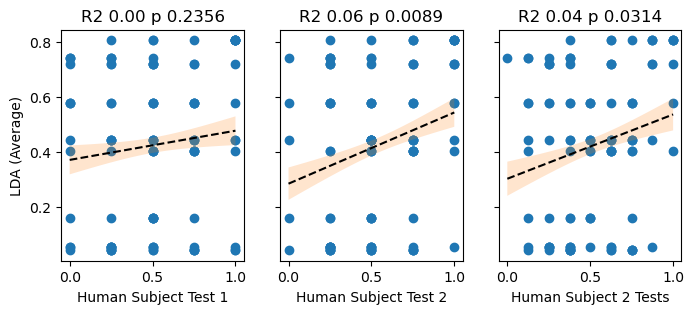

In [28]:

fig = plt.figure(figsize = (8,3))
ax = fig.subplots(nrows=1, ncols=3, sharey=True)


# Test 1 
x = subjectInfo['success_test1']
y = subjectInfo['predSuccess']

ax[0].scatter(x,y)
ax[0].set_xlabel('Human Subject Test 1')
ax[0].set_ylabel('LDA (Average)')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[0].plot(xsel, y_est, '--', color = 'k')
ax[0].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[0].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )

# Test 2 
x = subjectInfo['success_test2']

ax[1].scatter(x,y)
ax[1].set_xlabel('Human Subject Test 2')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[1].plot(xsel, y_est, '--', color = 'k')
ax[1].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[1].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )

# Test 1 and 2 
x = subjectInfo['success_2tests']

ax[2].scatter(x,y)
ax[2].set_xlabel('Human Subject 2 Tests')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[2].plot(xsel, y_est, '--', color = 'k')
ax[2].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[2].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )



plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/LDAvsHumanSameAssigned.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


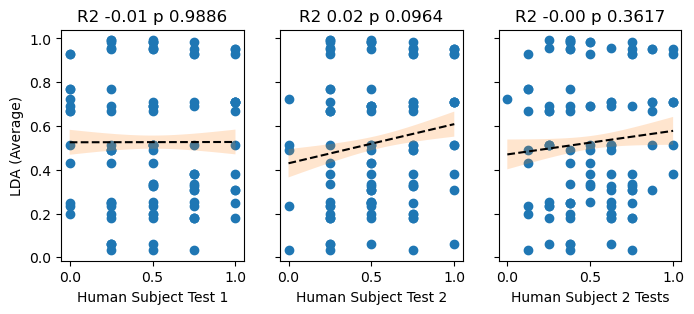

In [29]:
fig = plt.figure(figsize = (8,3))
ax = fig.subplots(nrows=1, ncols=3, sharey=True)


# Test 1 
x = subjectInfo['success_test1']
y = subjectInfo['predSuccessI']

ax[0].scatter(x,y)
ax[0].set_xlabel('Human Subject Test 1')
ax[0].set_ylabel('LDA (Average)')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[0].plot(xsel, y_est, '--', color = 'k')
ax[0].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[0].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )

# Test 2 
x = subjectInfo['success_test2']

ax[1].scatter(x,y)
ax[1].set_xlabel('Human Subject Test 2')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[1].plot(xsel, y_est, '--', color = 'k')
ax[1].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[1].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )

# Test 1 and 2 
x = subjectInfo['success_2tests']

ax[2].scatter(x,y)
ax[2].set_xlabel('Human Subject 2 Tests')

# fit a linear curve an estimate its y-values and their error.
xsel, y_est, y_err, r2adj, fval, pval = linefit(x, y)
ax[2].plot(xsel, y_est, '--', color = 'k')
ax[2].fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax[2].set(title='R2 %.2f p %.4f' % ( r2adj, pval) )

plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/LDAvsHumanSameTest.eps')

In [30]:
subjectInfo.describe()

,success_test1,success_test2,success_2tests,predSuccess,predSuccessI
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.502500,0.540000,0.521250,0.424293,0.526131
std,0.312805,0.279158,0.255653,0.277435,0.298703
min,0.000000,0.000000,0.000000,0.042595,0.032252
25%,0.250000,0.250000,0.375000,0.132225,0.251171
50%,0.500000,0.500000,0.500000,0.443209,0.511319
75%,0.750000,0.750000,0.750000,0.718659,0.713142
max,1.000000,1.000000,1.000000,0.806031,0.991761
